In [9]:
from utils.utils import calculate_attributions
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
import pandas as pd
import numpy as np
dataset = "GunPoint"
task  = 'task_1'


output_directory = f'G:/My Drive/master thesis/code/xai-tsc/results/ucr/{dataset}/fcn/fcn_itr_/original/'
att_train = np.load(output_directory + f"calculated_attribution_train_{task}.npy",allow_pickle=True)
att_test = np.load(output_directory + f"calculated_attribution_test_{task}.npy",allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_itr_/original/calculated_attribution_train_task_1.npy'

In [97]:
root_dir = 'G:/My Drive/master thesis/code/xai-tsc'
archive_name = 'ucr'
classifier = 'fcn_mt_ae_itr_0'
dataset_name =  'GunPoint'
data_source = 'pointwise'
mode = 'mtl'

from utils.utils import read_dataset

def calculate_att(root_dir, archive_name, classifier, dataset_name, data_source, mode, task=1):
    #import tensorflow_addons as tfa
    import tensorflow.keras as keras
    import sklearn
    import os

    max_length = 2000
    
    if task == 1: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,  'original')
    elif task == 2: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name,   data_source)
        
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    
    print(f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5')
    model = keras.models.load_model( f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                        + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                        + f'best_model.hdf5',compile=False)

    if mode == 'stl': 
        relu, softm = (-3,-1)
    if mode == 'mtl': 
        relu, softm = (3,-2)
    #print(model.layers[relu])
    w_k_c = model.layers[softm].get_weights()[0]  # weights for each filter k for each class c
        
    # the same input
    new_input_layer = model.inputs
    new_output_layer = [model.layers[relu].output, model.layers[softm].output]
    new_feed_forward = keras.backend.function(new_input_layer, new_output_layer)
    output = []

    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()
        for idx,ts in enumerate(x_vals):
            ts = ts.reshape(1, -1, 1)
            [conv_out, predicted] = new_feed_forward([ts])
            cas = np.zeros(dtype=np.float64, shape=(conv_out.shape[1]))
            for k, w in enumerate(w_k_c[:,int(y_vals[idx]-1)]):
                cas += w * conv_out[0, :, k] 
            attr.append([y_vals,orgx_vals[idx],cas])
        output.append(attr)
    return output
att_train,att_test = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

"/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5"

G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_0/pointwise/best_model.hdf5


'/content/drive/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_itr_/original/best_model.hdf5'

In [51]:
import tensorflow.keras as keras
att = calculate_att(root_dir, archive_name, classifier,  dataset_name, data_source, mode, task=1)

G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_/pointwise/best_model.hdf5


In [54]:
len(att[0]), len(att[1])

(50, 150)

In [30]:
path = 'G:/My Drive/master thesis/code/dl-4-tsc-mtl/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_/pointwise/best_model.hdf5'
model = keras.models.load_model(path)

SHAPE (150,)


2

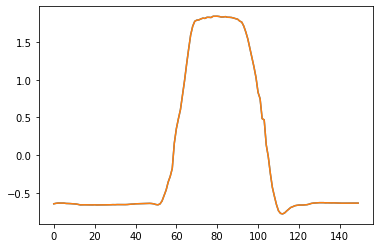

In [76]:
from utils.utils import read_dataset
plt.plot(att[0][0][1])
x = att[0][0][1]
data_p = 'G:/My Drive/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
data_source = ''
xt = read_dataset(data_p, archive_name, dataset_name,  data_source)['GunPoint'][0]
plt.plot(xt[0])
print("SHAPE",xt[0,:].flatten().shape)
pred = model.predict(xt)
len(pred[0][1])

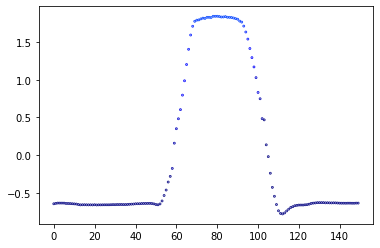

In [23]:
%matplotlib inline

plt.scatter(np.arange(len(att_train[0][1])),att_train[0][1],c=att_train[0][2]*100,cmap='jet', marker='.', s=2, vmin=0, vmax=100, linewidths=2.0)

In [90]:
def create_pointwise_explanation(attributions):
    output = []
    for split in attributions:
        explanations = []
        for ts in split: 
            x_values = ts[1]
            attributions = ts[2]
            explanations.append(np.concatenate((np.array([x_values]),attributions), axis=None))    
        output.append(np.array(explanations))
    return output

create_pointwise_explanation(att)[0][:,150:].shape


(50, 150)

In [ ]:
def save_explanations(data, root_dir, archive_name, appendix, dataset_name):
    train_explanation,test_explanation = data
    print(train_explanation.shape, test_explanation.shape)
    dir_path = root_dir + '/archives/' + archive_name + '/' + dataset_name + '/' + appendix + '/' 
    create_directory(dir_path)
    np.savetxt(dir_path + dataset_name + "_TRAIN", train_explanation, delimiter=',')
    np.savetxt(dir_path + dataset_name + "_TEST", test_explanation, delimiter=',')
    print("Successfully created explanation done.")

In [154]:
#G:\My Drive\master thesis\code\xai-tsc\results\ucr\GunPoint\fcn\fcn_mt_ae_itr_\pointwise\last_model.hdf5

model = keras.models.load_model("G:/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint/fcn/fcn_mt_ae_itr_/pointwise/last_model.hdf5",compile=False)

In [155]:
model.predict(data[:,150:][:3])[1][0]

array([[-0.20430014],
       [ 0.1789974 ],
       [ 0.17618676],
       [ 0.17667562],
       [ 0.17724483],
       [ 0.17740472],
       [ 0.1775343 ],
       [ 0.17753334],
       [ 0.17749923],
       [ 0.17745827],
       [ 0.17741309],
       [ 0.17740051],
       [ 0.17739625],
       [ 0.17740081],
       [ 0.17737551],
       [ 0.17735569],
       [ 0.17725973],
       [ 0.17718048],
       [ 0.17701624],
       [ 0.17685342],
       [ 0.17670414],
       [ 0.17657694],
       [ 0.17648779],
       [ 0.17643538],
       [ 0.17641136],
       [ 0.17642708],
       [ 0.17643653],
       [ 0.17646167],
       [ 0.17646933],
       [ 0.17647384],
       [ 0.1764716 ],
       [ 0.1764451 ],
       [ 0.17643994],
       [ 0.17639247],
       [ 0.1763582 ],
       [ 0.17634922],
       [ 0.17630465],
       [ 0.17614058],
       [ 0.1760963 ],
       [ 0.17635298],
       [ 0.17695633],
       [ 0.17796569],
       [ 0.17900284],
       [ 0.17988849],
       [ 0.18065317],
       [ 0

In [134]:
data[:, 150:].shape

(150, 150)

In [139]:
og = data = np.loadtxt("G:/My Drive/master thesis/code/xai-tsc/archives/ucr/GunPoint/GunPoint_TEST", delimiter=',')
data = np.loadtxt("G:/My Drive/master thesis/code/xai-tsc/archives/ucr/GunPoint/pointwise/GunPoint_TEST", delimiter=',')
print(data[:, 150:].shape)

(150, 150)


In [138]:
og[:,1:].shape

(150, 150)

In [120]:
print(data[:, 150:])

[[ 0.02588516 -0.10093396 -0.10724084 ... -0.07832859 -0.07566263
   0.01876664]
 [-0.14650711 -0.16034801 -0.1862706  ... -0.15906834 -0.12043785
  -0.12671112]
 [-0.21819342 -0.30479137 -0.36415169 ... -0.15210651 -0.12596103
  -0.13162597]
 ...
 [-0.1517915  -0.17032931 -0.20088355 ... -0.15895985 -0.12040637
  -0.12666015]
 [-0.16589977 -0.22207369 -0.25013364 ... -0.19632843 -0.12937937
  -0.13104325]
 [ 0.01152732 -0.13546261 -0.14866648 ... -0.05229307 -0.06233977
   0.01569845]]
